# Data Preparation

In [1]:

import kagglehub
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# Download the dataset from kagglehub
path = kagglehub.dataset_download("arashnic/uplift-modeling")
print("Path to dataset files:", path)

files = os.listdir(path)
print("Files in dataset:", files)

for file in files:
    if file.endswith(".csv"):
        file_path = os.path.join(path, file)
        print(f"Loading file: {file}")
        data = pd.read_csv(file_path)
        break  # get the first csv

Path to dataset files: /root/.cache/kagglehub/datasets/arashnic/uplift-modeling/versions/1
Files in dataset: ['criteo-uplift-v2.1.csv']
Loading file: criteo-uplift-v2.1.csv


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

class KaggleDataReader:
    def __init__(self, path, treatment_col='treatment', conversion_col='conversion', visit_col='visit', exposure_col='exposure', feature_cols=None, test_size=0.2, random_state=42, sample_frac=0.4, balance=False):

        self.path = path
        self.treatment_col = treatment_col
        self.conversion_col = conversion_col
        self.visit_col = visit_col
        self.exposure_col = exposure_col
        self.feature_cols = feature_cols or [f'f{i}' for i in range(12)]
        self.test_size = test_size
        self.random_state = random_state
        self.sample_frac = sample_frac
        self.balance = balance

        # Load the data
        data = pd.read_csv(path)

        # sampling - 40%
        self.data = data.groupby(self.treatment_col, group_keys=False).apply(
            lambda x: x.sample(frac=self.sample_frac, random_state=self.random_state)
        )

        if self.balance:
            self._balance_data()

        # Split data into train, validate, and test
        self._split_data()

    def _balance_data(self):
        """
        Balances the dataset for treatment=0 and treatment=1 by oversampling or undersampling.
        """
        treatment_0 = self.data[self.data[self.treatment_col] == 0]
        treatment_1 = self.data[self.data[self.treatment_col] == 1]

        if len(treatment_0) < len(treatment_1):
            # Oversample treatment=0
            treatment_0 = resample(
                treatment_0,
                replace=True,
                n_samples=len(treatment_1),
                random_state=self.random_state
            )
        else:
            # Oversample treatment=1
            treatment_1 = resample(
                treatment_1,
                replace=True,
                n_samples=len(treatment_0),
                random_state=self.random_state
            )

        # Combine and shuffle
        self.data = pd.concat([treatment_0, treatment_1]).sample(frac=1, random_state=self.random_state)

    def _split_data(self):
        """
        Splits the dataset into training, validation, and test sets.
        """
        self.features = self.data[self.feature_cols].values
        self.actions = self.data[self.treatment_col].values
        self.labels = self.data[self.visit_col].values

        # (features, action, labels)
        self.datas = list(zip(self.features, self.actions, self.labels))

        # Train-test split
        train_data, test_data = train_test_split(
            self.datas, test_size=self.test_size, stratify=[x[1] for x in self.datas], random_state=self.random_state
        )

        # Further split- training and validation
        self.train_data, self.validate_data = train_test_split(
            train_data, test_size=0.25, stratify=[x[1] for x in train_data], random_state=self.random_state
        )

        self.test_data = test_data

    def get_data(self):
        return {
            'train': self.train_data,
            'validate': self.validate_data,
            'test': self.test_data
        }

    def print_proportions(self):
        def calculate_proportions(data, label=""):
            actions = [x[1] for x in data]
            unique, counts = np.unique(actions, return_counts=True)
            proportions = {int(k): round(v / len(actions), 2) for k, v in zip(unique, counts)}
            print(f"{label} Proportions: {proportions}")

        calculate_proportions(self.train_data, "Train")
        calculate_proportions(self.validate_data, "Validate")
        calculate_proportions(self.test_data, "Test")


In [4]:
kaggle_reader = KaggleDataReader(path=file_path, balance=True)

data = kaggle_reader.get_data()

print("Train Data Shapes:")
print(len(data['train']), len(data['train'][0]))
print("Validate Data Shapes:")
print(len(data['validate']), len(data['validate'][0]))
print("Test Data Shapes:")
print(len(data['test']), len(data['test'][0]))

# Print proportions
kaggle_reader.print_proportions()


<ipython-input-3-b0ed7850ce35>:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.data = data.groupby(self.treatment_col, group_keys=False).apply(


Train Data Shapes:
5703674 3
Validate Data Shapes:
1901225 3
Test Data Shapes:
1901225 3
Train Proportions: {0: 0.5, 1: 0.5}
Validate Proportions: {0: 0.5, 1: 0.5}
Test Proportions: {0: 0.5, 1: 0.5}


# Qini Curves

In [9]:
import matplotlib.pyplot as plt

In [10]:
def rec2qini(recs):
    '''
    recs = [[algo, real, response, prob]]
    '''
    y_true, d_pred, group = [], [], []
    for rec in recs:
        # print('rec', rec)
        y_true.append(rec[1])
        d_pred.append(rec[0])
        group.append(rec[2])

    return y_true, d_pred, group

def data2rec(datas, n_action=2):
    recs = []
    for data in datas:
        algo_action = np.argmax(data[:n_action])
        real_action = int(data[-1])
        reaction = data[n_action]
        recs.append([algo_action, real_action, reaction])
    return recs

In [12]:

def number_responses(y_true, group):

    responses_target, responses_control, n_target, n_control = 0, 0, 0, 0
    for is_target, y in zip(group, y_true):
        if is_target:
            n_target += 1
            responses_target += y
        else:
            n_control += 1
            responses_control += y

    rescaled_responses_control = 0 if n_control == 0 else responses_control * \
        n_target / n_control

    return responses_target, rescaled_responses_control

def null_uplift_curve(y_true, group):

    responses_target, rescaled_responses_control = number_responses(
        y_true, group)
    return [0, len(y_true)], [0, responses_target - rescaled_responses_control]

def optimal_uplift_curve(y_true, group, negative_effects=True):

    responses_target, rescaled_responses_control = number_responses(
        y_true, group)

    if negative_effects:
        xs = [0, responses_target, len(
            y_true) - rescaled_responses_control, len(y_true)]
        ys = [0, responses_target, responses_target,
              responses_target - rescaled_responses_control]
    else:
        xs = [0, responses_target - rescaled_responses_control, len(y_true)]
        ys = [0, responses_target - rescaled_responses_control,
              responses_target - rescaled_responses_control]

    return xs, ys

In [16]:

def uplift_curve(y_true, d_pred, group, n_nodes=None):
    if n_nodes is None:
        n_nodes = min(len(y_true) + 1, 200)

    sorted_ds = sorted(zip(d_pred, group, y_true), reverse=True)
    responses_control, responses_target, n_control, n_target = 0, 0, 0, 0
    cumulative_responses = [
        (responses_control, responses_target, n_control, n_target)]

    # print('sorted_ds', sorted_ds)
    for _, is_target, response in sorted_ds:
        if is_target:
            n_target += 1
            responses_target += response
        else:
            n_control += 1
            responses_control += response
        cumulative_responses.append(
            (responses_control, responses_target, n_control, n_target))

    # print('n_nodes', n_nodes)
    # print('cumulative_responses')
    # for ele in cumulative_responses:
    #     print(ele)
    xs = [int(i) for i in np.linspace(0, len(y_true), n_nodes)]
    ys = [_uplift(*cumulative_responses[x]) for x in xs]

    return xs, ys



def _uplift(responses_control, responses_target, n_control, n_target):
    if n_control == 0:
        return responses_target
    else:
        return responses_target - responses_control * n_target * 1. / n_control

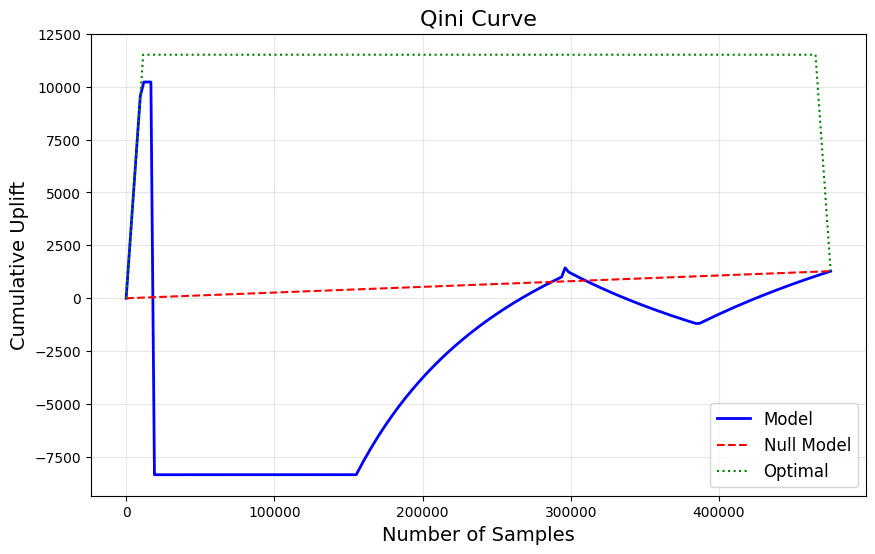

In [17]:

# Qini Curve Plotting Function
def plot_qini_curve(y_true, d_pred, group):
    # Generate the curves (model, null, and optimal)
    xs_model, ys_model = uplift_curve(y_true, d_pred, group)
    xs_null, ys_null = null_uplift_curve(y_true, group)
    xs_optimal, ys_optimal = optimal_uplift_curve(y_true, group)

    # Plot the curves
    plt.figure(figsize=(10, 6))
    plt.plot(xs_model, ys_model, label="Model", color="blue", linewidth=2)
    plt.plot(xs_null, ys_null, label="Null Model", color="red", linestyle="--")
    plt.plot(xs_optimal, ys_optimal, label="Optimal", color="green", linestyle=":")

    # Format the plot
    plt.title("Qini Curve", fontsize=16)
    plt.xlabel("Number of Samples", fontsize=14)
    plt.ylabel("Cumulative Uplift", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

# Convert data to records
datas = np.load('/content/test_max_2025_01_09_21_12_37.npy')

recs = data2rec(datas)

# # Extract the data for Qini curve
y_true, d_pred, group = rec2qini(recs)

plot_qini_curve(y_true, d_pred, group)